In [1]:
#!pip install wordcloud

# Adverse Events WordClouds

In [2]:
from tqdm import tqdm
import pandas as pd
from functools import reduce
from io import open
import json
from datetime import date,datetime, timedelta
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from ast import literal_eval

In [3]:
df = None
for ym in ["2020-12"] + [f"2021-0{k}" for k in range(1,10)]:
    tmp = pd.read_csv(f"../data/{ym}.csv")
    if df is None:
        df = tmp
    else:
        df = pd.concat((df, tmp))

for col_name in ["entities", "sentiment_value", "vaccines"]:
    df[col_name] = df[col_name].apply(lambda x: literal_eval(x) if not pd.isna(x) else x) 
df.reset_index(drop=True, inplace=True)
ANALYZE_DAYS = False

df = df[df.entities.str.len()>0]
df = df[~df.sentiment_value.isna()]
df = df[df.created_at < "2021-09-07"]
df["roberta_label"] = df.sentiment_value.apply(lambda row: row["label"])
df["full_eng_"] = df.entities.apply(lambda x: [ent["text"]["full_eng"] for ent in x])

new_df = []
for idx, row in df.iterrows():
    d = row.to_dict()
    for vax in d["vaccines"]:
        d2 = d.copy()
        del d2["vaccines"]
        d2["vaccine_name"] = vax
        new_df.append(d2)
df = pd.DataFrame(new_df)

new_df = []
for idx, row in df.iterrows():
    d = row.to_dict()
    for vax in d["full_eng_"]:
        d2 = d.copy()
        del d2["full_eng_"]
        d2["full_eng"] = vax
        new_df.append(d2)
df = pd.DataFrame(new_df)

df["ym"] = df.created_at.astype(str).str[:-3]

# df = df[df.ym.str.split("-").str[-1] != "09"]

data = []
for _date, d in df[df.vaccine_name == "astrazeneca"].groupby("created_at"):
    
    vc = d.roberta_label.value_counts()
    
    item = {
        "date": _date,
        "pos_sum": vc["LABEL_2"] / len(d) if "LABEL_2" in vc else 0,
        "neu_sum": vc["LABEL_1"] / len(d) if "LABEL_1" in vc else 0,
        "neg_sum": vc["LABEL_0"] / len(d) if "LABEL_0" in vc else 0,
    }

    data.append(item)
    
data = pd.DataFrame(data)


data.index = data.date
data.drop("date", axis=1, inplace = True)


data["pos_ewm"] = data.pos_sum.ewm(halflife = "4 days", times=pd.DatetimeIndex(data.index)).mean()
data["neu_ewm"] = data.neu_sum.ewm(halflife = "4 days", times=pd.DatetimeIndex(data.index)).mean()
data["neg_ewm"] = data.neg_sum.ewm(halflife = "4 days", times=pd.DatetimeIndex(data.index)).mean()

In [4]:
def wc(df, mode="freq"):

    wordcloud = WordCloud(
        font_path="assets/bahnschrift.ttf",
        width=250,
        height=200,
        margin=10,
        background_color = 'white',
        max_words=200,
        max_font_size = 250,
        collocations=False,
        color_func=lambda *args, **kwargs: "black",
        scale = 2,
        random_state = 10,
    )
    
    if mode == "freq":
        vc = df.full_eng.value_counts()
        vc = vc[(vc.index.str.len() > 2)]
        freq = vc.to_dict() #df.full_eng.value_counts().to_dict()
        if "jabs" in freq: del freq["jabs"]
        wordcloud.generate_from_frequencies(freq)
        
    elif mode == "text":
        text = " ".join([x for x in df.full_eng.tolist() if x != "jabs"])
        wordcloud.generate(text)

    font_sizes = [item[1] for item in wordcloud.layout_]
    most_freq_words = [k for k,v in wordcloud.words_.items()][:5]
    
    for w in most_freq_words:
        print(w)
    
    len(set(font_sizes))

    MIN = min(font_sizes)
    MAX = max(font_sizes)

    def my_color_func(word, font_size, position, orientation, font_path, random_state):

        k = [(0.8, "#000"), (0.6, "#333"), (0.3, "#666")]

        fperc =  font_size/(MAX-MIN) if (MAX-MIN) != 0 else 0

        for (perc, col) in k:

            if fperc > perc:
                return col

        return "#999"

    wordcloud.recolor(random_state=None, color_func=my_color_func)
    return wordcloud

In [5]:
def wc_per_gb(gb, name="out"):
    
    fig, axs = plt.subplots(ncols=len(gb), figsize=(len(gb)*5, 5))
    
    fig.subplots_adjust(hspace=0, wspace=0)
    
    for i,(gname, data) in enumerate(gb):
        print(gname)
        cloud = wc(data, mode="text")
        axs[i].imshow(cloud, interpolation='none')
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].margins(x=.3, y=.3)
        
    fig.patch.set_facecolor("white")
    plt.savefig(f"output/plot_cloud_{name}.pdf", bbox_inches="tight")

    plt.show()

In [6]:
def wc_per_ym_per_vax(data):
    
    gb = data.groupby("ym")
    
    scale = 3
    
    vax_to_int = {name:idx+1 for idx,name in enumerate(["astrazeneca", "moderna", "pfizer", "sinopharm", "sinovac", "sputnik", "johnson & johnson"])}
    int_to_vax = {v:k for k,v in vax_to_int.items()}
    int_to_vax[0] = "global"
    
    ncols = len(gb)
    nrows = len(df.vaccine_name.unique())+1
    
    fig, axs = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        gridspec_kw = {'wspace':0, 'hspace':0},
        constrained_layout = True
    )
    
    for i,(ym, data) in enumerate(gb):
        
        cloud = wc(data, mode="text")
        axs[0,i].imshow(cloud, interpolation='none')

    
    for i,(ym, data_) in enumerate(gb):
        
        for j, (vax, data) in enumerate(data_.groupby("vaccine_name")):
            
            if vax in vax_to_int:
                cloud = wc(data, mode="text")
                axs[vax_to_int[vax],i].imshow(cloud, interpolation='none')
  
    for i in range(ncols):
        
        for j in range(nrows):
            axs[j,i].set_xticks([])
            axs[j,i].set_yticks([])
            axs[j,i].margins(x=0, y=0)
            
            if i == 0:
                axs[j,i].set_ylabel(int_to_vax[j].title())
            

    fig.subplots_adjust(wspace=0, hspace=0)

    plt.savefig("output/all_cloud_en.pdf")
    plt.savefig("output/all_cloud_en.jpg")

    plt.show()

global
2020-12
allergic
reaction
arm
headache
allergies
2021-01
allergic
reaction
arm
sore
headache
2021-02
arm
sore
headache
reaction
fever
2021-03
arm
sore
clot
reaction
headache
2021-04
clot
arm
sore
headache
fever
2021-05
clot
arm
sore
headache
fever
2021-06
heart
inflammation
arm
clot
immune
2021-07
immune
clot
arm
reaction
heart
2021-08
arm
sore
headache
fever
clot
2021-09
heart
immune
clot
headache
allergic


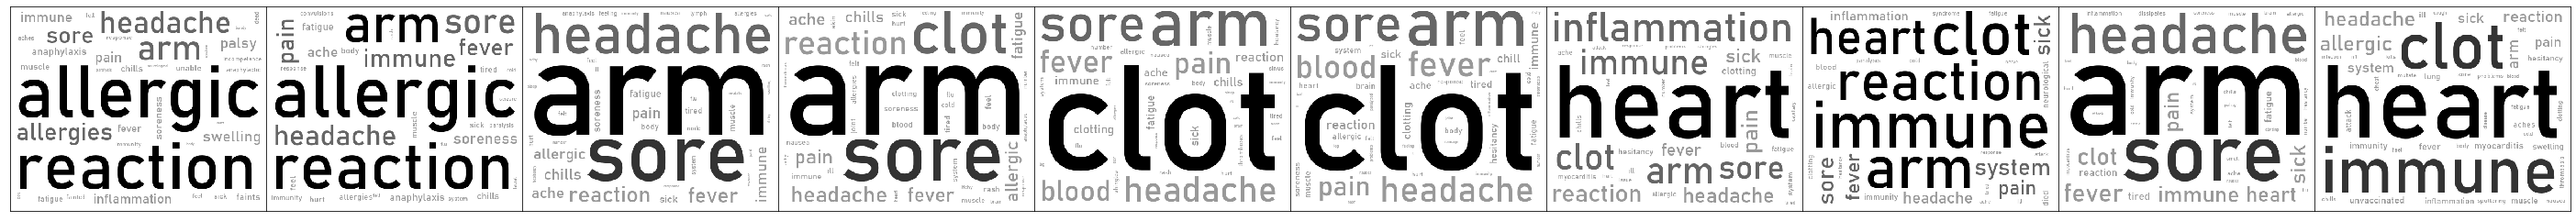

----------------------------------------
### astrazeneca ###
clot
blood
headache
clotting
pain
2020-12
headache
neurological
bumpy
dead
reaction
2021-01
headache
incompetence
immune
arm
pain
2021-02
arm
headache
sore
reaction
pain
2021-03
clot
blood
pain
headache
clotting
2021-04
clot
blood
clotting
headache
thrombosis
2021-05
clot
blood
headache
clotting
reaction
2021-06
clot
clotting
blood
headache
capillary
2021-07
clot
clotting
blood
immune
headache
2021-08
clot
headache
dissipates
blood
brain
2021-09
clot
headache
thrombosis
pain
clotting


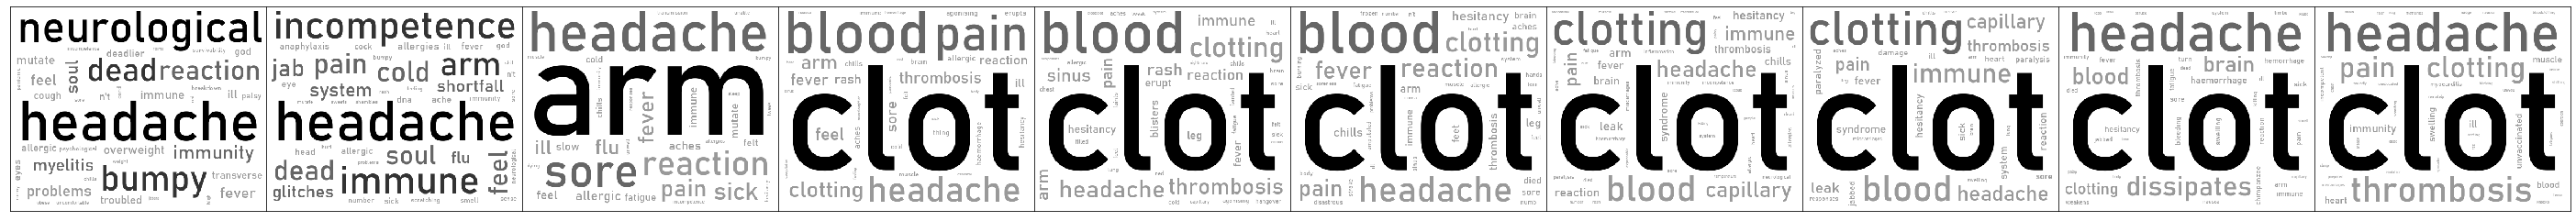

----------------------------------------
### pfizer ###
arm
reaction
sore
allergic
headache
2020-12
allergic
reaction
palsy
allergies
headache
2021-01
reaction
allergic
arm
sore
headache
2021-02
arm
sore
reaction
headache
allergic
2021-03
arm
sore
reaction
headache
allergic
2021-04
arm
sore
headache
clot
pain
2021-05
arm
sore
headache
fever
immune
2021-06
heart
inflammation
arm
sore
immune
2021-07
heart
arm
system
sore
immune
2021-08
arm
sore
heart
fever
dissipates
2021-09
immune
heart
allergic
system
reaction


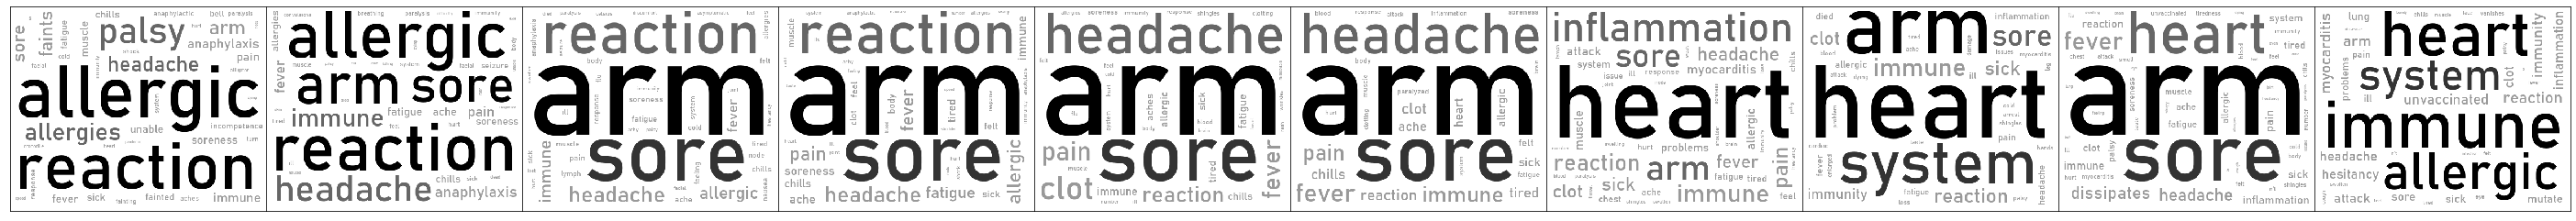

----------------------------------------
### moderna ###
arm
reaction
sore
allergic
fever
2020-12
reaction
allergic
swelling
arm
inflammation
2021-01
allergic
reaction
arm
sore
soreness
2021-02
arm
sore
headache
fever
chills
2021-03
arm
sore
reaction
fever
headache
2021-04
arm
sore
fever
headache
chills
2021-05
arm
sore
fever
chills
headache
2021-06
inflammation
heart
arm
immune
sore
2021-07
arm
sore
reaction
immune
sick
2021-08
arm
sore
fever
headache
tired
2021-09
arm
aches
pain
fever
sputtering


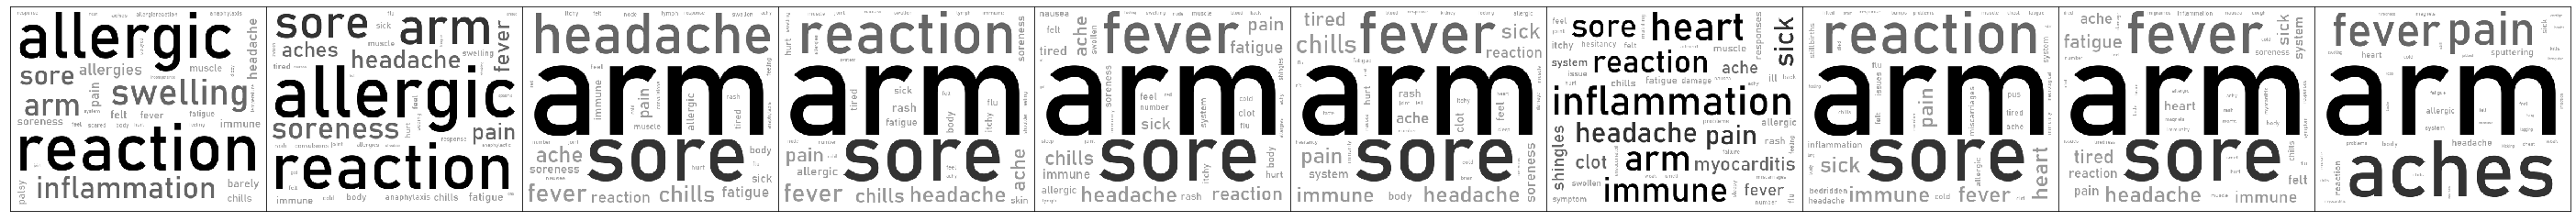

----------------------------------------
### sputnik ###
clot
fever
immune
hesitancy
headache
2021-02
bitten
putrid
stench
slimy
ventilator
2021-03
race
roulette
clot
blinkers
incompetence
2021-04
clot
fever
clotting
headache
infected
2021-05
clot
cold
sloppiness
sputtering
blood
2021-06
fever
immune
hesitancy
cold
spinning
2021-07
hesitancy
n't
headache
feel
arm
2021-08
hesitancy
sore
arm
cough
headache
2021-09
sick


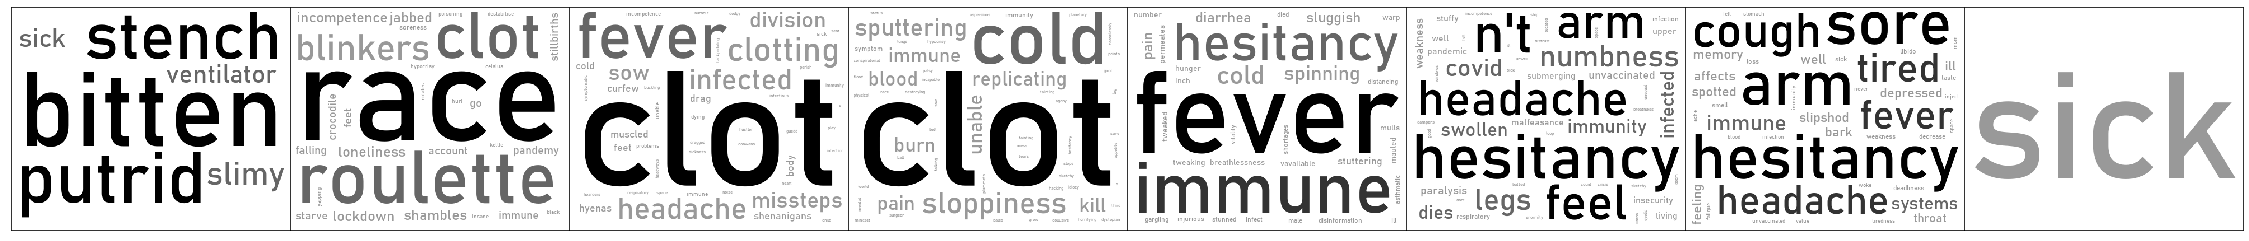

----------------------------------------
### sinopharm ###
immune
arm
immunity
hesitancy
fever
2021-02
painless
sore
arm
fever
fatigue
2021-03
immune
fever
responses
immunity
cell
2021-04
immunity
immune
responses
fever
flu
2021-05
immune
responses
hesitancy
clot
spooked
2021-06
fever
hungry
hesitancy
arm
immune
2021-07
hesitancy
arm
immune
immunity
sick
2021-08
sore
arm
sick
felt
flu
2021-09
flu


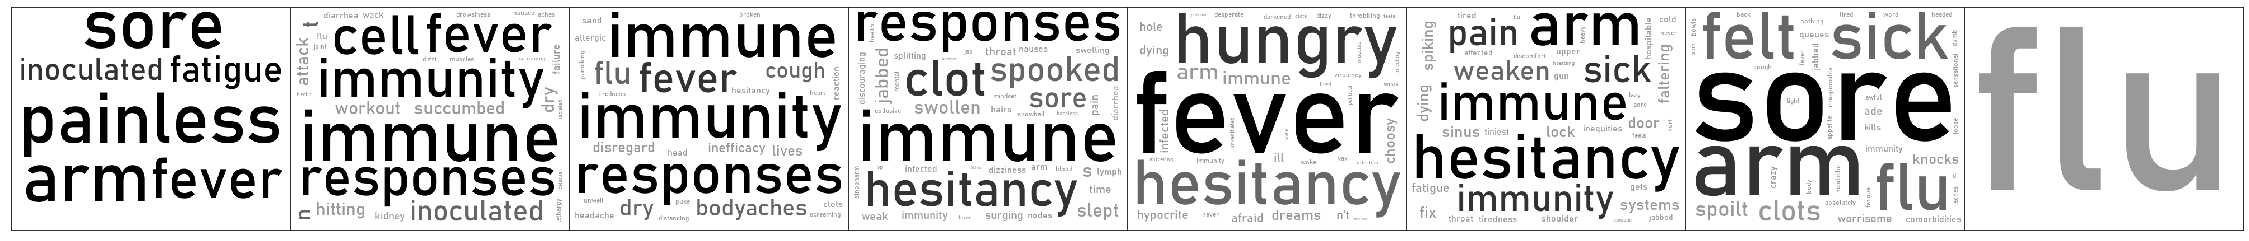

----------------------------------------
### sinovac ###
fever
immune
palsy
hesitancy
pain
2021-02
pandering
attacked
symptom
2021-03
blood
immune
hesitancy
dizzy
clotting
2021-04
paralysis
stroke
feel
pain
clots
2021-05
comorbidities
pain
immune
morbidity
infected
2021-06
fever
hesitancy
inequities
sick
allergies
2021-07
fever
immune
headache
died
pain
2021-08
palsy
paralysis
allergic
immune
sick
2021-09
comorbidities
herd
without
distance
crazy


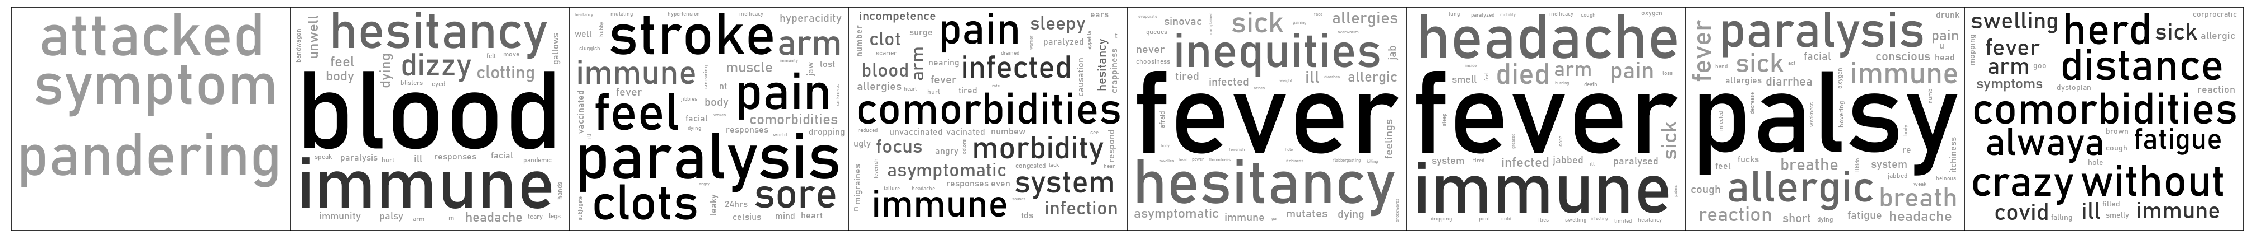

----------------------------------------
### johnson & johnson ###
clot
immune
clotting
blood
reaction
2021-04
clot
blood
clotting
headache
pain
2021-05
clot
clotting
hesitancy
blood
fainting
2021-06
life
shattered
s
daughter
clot
2021-07
immune
neurological
system
syndrome
nerve
2021-08
immune
clot
sore
fever
immunity
2021-09
clotting
ill
heads
hamstringing
chills


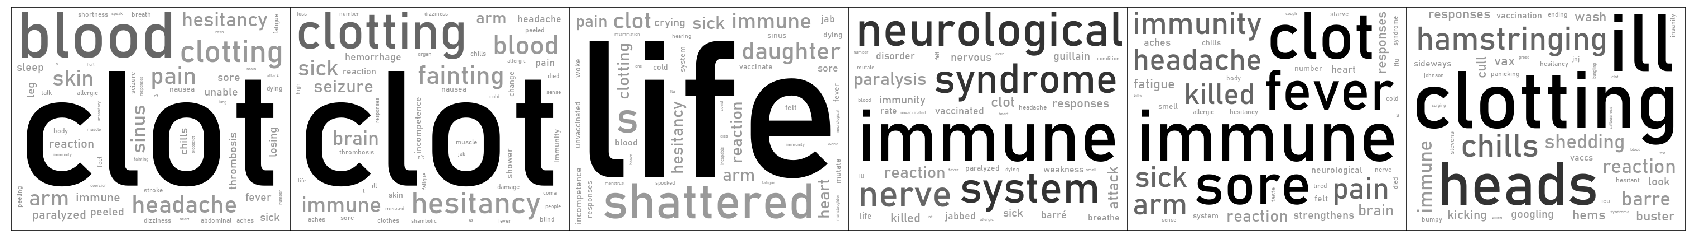

In [7]:
print("global")
wc_per_gb(df.groupby("ym"), "global")

for vax in df.vaccine_name.unique():
    print("-"*40)
    print(f"### {vax} ###")
    wc(df[df.vaccine_name == vax], mode="text")
    wc_per_gb(df[df.vaccine_name == vax].groupby("ym"), vax)